# По материалам 16 семинара провести исследование по тематическому моделированию и разработать рекомендательную систему.

* рекомендательная система обучается на корпусе текстов, в качестве корпуса текстов использовать 20 news groups из scikit-learn
* пользователь предъявляет образец текста (не обязательно из обучающего корпуса) и просит показать k похожих по тематике текстов
* в качестве моделей для тематического моделирования рассмотреть NMF, LSA, LDA
* в качестве метрик topic coherence рассмотреть TC-W2C, UCI, Umass для топ-20 слов-дескрипторов тем
* для каждой тематической модели определить оптимальное кол-во тем, а затем сравнить сами модели с помощью метрик topic coherence
* при выборе оптимального кол-ва тем постройте проверяйте дескрипторы тем
* таким образом, для каждой метрики вы получите свою оптимальную модель. Сравните дескрипторы тем у этих моделей, и выберите
* таким образом, вы получите тематическое представление для каждого документа. Выберите функцию расстояния между документами, посмотрите sklearn.metrics
* при поиске ближайших соседей используйте sklearn.neighbors
* работу оформить в виде ноутбука *.ipynb
* продемонстрируйте работу вашей рекомендательной системы на текстах из обучающего корпуса и текстах из bbc news за 2017 год
* Интерфейс рекомендательной ситемы:

# В качестве метрики расстояния между документами возьмем коэффициент Отиаи

# Импорты для nmf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Структура newsgroups_train:
    newsgroups_train.DESCR - дескрипшн
    newsgroups_train.data - данные, длина = 11314, содержат 11314 писем со своим хедером, телом и футером
    newsgroups_train.target - массив таргетов
    newsgroups_train.target_names - массив дескрипшнов для таргетов, длина - 20, лейблы от 0 до 19

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
newsgroups_train = fetch_20newsgroups(subset='train',
                                     remove=('headers', 'footers', 'quotes'));

Удалим мусор в виде хедеров и прочего

# Получаем вполне читабельный текст

In [5]:
newsgroups_train.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [6]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# Делаем препроцессинг данных

In [7]:
newsgroups_train.data[0].lower()[0:100]

'i was wondering if anyone out there could enlighten me on this car i saw\nthe other day. it was a 2-d'

In [8]:
raw_documents = []
snippets = []
for line in newsgroups_train.data:
    text = line.strip()
    raw_documents.append(text.lower())
        
    snippets.append(text[0 : min(len(text), 100)])
print("Read %d raw text documents" % len(raw_documents))

Read 11314 raw text documents


In [9]:
snippets[1]

'A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences fo'

# Загружаем стопворды

In [10]:
custom_stop_words = []
with open("stopwords.txt", "r") as f:
    for line in f.readlines(): custom_stop_words.append(line.strip().lower())

print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 350 entries


# Создаем ${TF-IDF}$ модель.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df=20)
A = vectorizer.fit_transform(raw_documents)

print("Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]))
terms = vectorizer.get_feature_names()
joblib.dump((A,terms,snippets), "my-articles.pkl") # сохраняем дамп матрицы, термов и сниппетов

Created 11314 X 6004 TF-IDF-normalized document-term matrix


['my-articles.pkl']

# Попробуем в качестве метрики расстояния между документами ${d_i}$ и ${d_j}$ брать MSE между строками ${tf-idf}$ или ${W2V}$ матрицы, где ${k}$-той строке соответствует документ ${d_{k}}$, можно брать и метрику MAE, но MSE более чувствительна к ошибкам, то есть если МАЕ между документами ${d_i}$ и ${d_j}$ большая, то MSE может быть много больше MAE

# Пример

In [62]:
s1 = "Шоколад - хорошее средство снятия стресса и".lower()
s2 = "Шоколад - популярный средство  для облегчения стресса".lower()
s3 = "Кролик это хищное животное, не поедающее шоколад".lower()

In [63]:
kl = [s1, s2, s3]

In [64]:
v = TfidfVectorizer()

In [65]:
m = v.fit_transform(kl)

In [66]:
m = m.todense()

In [67]:
m.shape

(3, 14)

In [68]:
sklearn.metrics.mean_squared_error(m[0], m[1]) # s1 и s2

0.08873702187314417

In [69]:
sklearn.metrics.mean_squared_error(m[1], m[2]) # s2 и s3

0.13353988333151798

In [71]:
sklearn.metrics.mean_squared_error(m[0], m[2]) # s1 и s3

0.13229424774043605

# Как мы можем видеть, метрика также вполне имеет место быть

# Мы получили нормализованную матрицу ${A_{(11314x6004)}}$ вида терм-документ, где на i,j-той позиции находится частотная характеристика j-го терма в i-том документе

# Взглянем на термы, имеющие максимальную частоту

In [12]:
import operator

sums = np.array(A.sum(axis=0)).ravel()

weights = { term: sums[col] for col, term in enumerate(terms)}
ranking = sorted(weights.items(), key=operator.itemgetter(1), reverse=True)
for i, pair in enumerate(ranking[0:20]): print("%s (%.2f)" % (pair[0], pair[1]))

know (183.69)
get (172.95)
people (160.03)
think (156.97)
good (133.11)
thanks (133.07)
time (127.37)
please (118.39)
edu (108.17)
see (102.61)
god (101.83)
need (101.57)
way (100.23)
want (98.14)
right (97.48)
problem (95.40)
system (94.64)
windows (93.58)
something (90.52)
really (89.58)


# В общем и целом статистика похожа на слова, часто применяемые в переписке

# Создаем модель
# Предполагаем, что ${A ≈ WH}$ , тогда минимизируем функционал 
# $min_{W, H}{||A - WH||}$

${Целевая \space функция: 
0.5 * ||A - WH||_{^2} + \alpha * L_1 * ||W||_1
+ \alpha * L_1 * ||H||_1
+ \alpha / 2 * (1 - L_1) * ||W||_2
+ \alpha / 2 * (1 - L_1) * ||H||_2
}$

${Где: ||A||_{2} = \sum_{i,j} A_{ij}^2, \space 
||A||_1 = \sum_{i,j} abs(A_{ij})}$

In [236]:
k = 20
model = NMF(init="nndsvd", n_components=k) 

W = model.fit_transform( A )
H = model.components_

In [237]:
(W.shape, H.shape)

((11314, 20), (20, 6004))

# Проверим размерность

In [238]:
A.shape == np.matmul(W, H).shape

True

In [239]:
np.argsort(H[2,:])[::-1][1]

973

# Проверим корректность кластеризации

In [242]:
def get_descriptor(terms, H, topic_index, top):
    top_indices = np.argsort(H[topic_index,:])[::-1]
    
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor(terms, H, topic_index, 11))
    str_descriptor = ", ".join(descriptors[topic_index])
    print("Claster %2d: %s" % (topic_index+1, str_descriptor ))

Claster  1: get, good, time, back, going, want, really, go, got, bike, see
Claster  2: thanks, please, mail, advance, hi, looking, email, info, address, send, post
Claster  3: geb, cadre, dsl, n3jxp, chastity, shameful, pitt, intellect, skepticism, surrender, gordon
Claster  4: god, jesus, bible, christ, faith, believe, christian, christians, church, life, sin
Claster  5: key, chip, encryption, clipper, keys, government, escrow, system, algorithm, public, security
Claster  6: drive, scsi, drives, disk, hard, ide, controller, floppy, cd, system, hd
Claster  7: windows, dos, version, running, os, microsoft, drivers, nt, run, driver, system
Claster  8: 10, 11, 12, 15, 16, 14, 17, 20, 13, 25, 24
Claster  9: 00, sale, shipping, offer, price, condition, asking, interested, 50, best, sell
Claster 10: game, team, games, players, hockey, season, play, win, teams, player, league
Claster 11: card, video, monitor, bus, vga, cards, drivers, color, driver, ram, memory
Claster 12: car, cars, engine, 

In [17]:
kmin, kmax = 1, 50

topic_models = []
for k in tqdm(range(kmin, kmax + 1)):
    model = NMF(init="nndsvd", n_components=k) 
    W = model.fit_transform(A)
    H = model.components_    
    topic_models.append((k, W, H))

100%|██████████| 50/50 [10:22<00:00, 12.45s/it]


# Получили вектор соответствий k -> W,H

In [76]:
import re
import gensim


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            

docgen = TokenGenerator(raw_documents, custom_stop_words)
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)
print( "Model has %d terms" % len(w2v_model.wv.vocab) )
w2v_model.save("w2v-model.bin")

Model has 8460 terms


# Посчитаем расстояние 

In [136]:
from itertools import combinations

def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
        
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = [] # Массив различных дескрипторов для всех k=1:20
    for topic_index in range(k):
    
        # Получаем k дескрипторов для каждого k-го кластера
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    # Сохраним k
    
    # Считает расстояние для текущего k
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]));

/home/artur/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


K=01: Coherence=0.2747
K=02: Coherence=0.2997
K=03: Coherence=0.5001
K=04: Coherence=0.5500
K=05: Coherence=0.5662
K=06: Coherence=0.5800
K=07: Coherence=0.5925
K=08: Coherence=0.6145
K=09: Coherence=0.6026
K=10: Coherence=0.5787
K=11: Coherence=0.5841
K=12: Coherence=0.5916
K=13: Coherence=0.6041
K=14: Coherence=0.5914
K=15: Coherence=0.5970
K=16: Coherence=0.6105
K=17: Coherence=0.6066
K=18: Coherence=0.6181
K=19: Coherence=0.6125
K=20: Coherence=0.6221
K=21: Coherence=0.6076
K=22: Coherence=0.6209
K=23: Coherence=0.6071
K=24: Coherence=0.6224
K=25: Coherence=0.6161
K=26: Coherence=0.6133
K=27: Coherence=0.6242
K=28: Coherence=0.6116
K=29: Coherence=0.6217
K=30: Coherence=0.6165
K=31: Coherence=0.6253
K=32: Coherence=0.6213
K=33: Coherence=0.6180
K=34: Coherence=0.6116
K=35: Coherence=0.6154
K=36: Coherence=0.6122
K=37: Coherence=0.6192
K=38: Coherence=0.6247
K=39: Coherence=0.6101
K=40: Coherence=0.6085
K=41: Coherence=0.6095
K=42: Coherence=0.6120
K=43: Coherence=0.6148
K=44: Coher

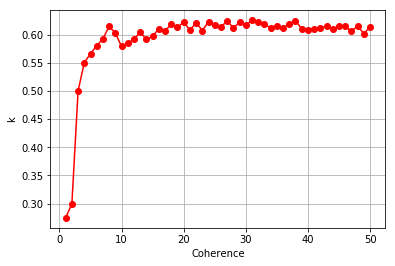

In [137]:
plt.grid(True)
plt.xlabel("Coherence")
plt.ylabel("k")
plt.plot(k_values, coherences, "o-r");

# Оптимальный ${k}$ положим ${20}$ для ${NMF}$ c ${coherence=0.6221}$, так как для ${k > 20}$ результат похож на переобучение

In [138]:
k = 16
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor(terms, H, topic_index, 20)
    str_descriptor = ", ".join(descriptor)
    print("\nClaster %02d: %s" % (topic_index + 1, str_descriptor ))


Claster 01: people, think, know, get, time, see, right, good, something, really, want, going, way, things, take, thing, gun, believe, sure, point

Claster 02: thanks, please, mail, know, advance, hi, looking, info, email, help, anybody, address, appreciated, information, post, someone, send, interested, need, find

Claster 03: geb, cadre, dsl, chastity, n3jxp, shameful, pitt, intellect, skepticism, surrender, gordon, banks, soon, edu, blood, patients, probably, medical, weight, usually

Claster 04: god, jesus, bible, christ, faith, believe, christian, christians, church, sin, life, heaven, lord, truth, hell, belief, man, christianity, father, son

Claster 05: key, chip, encryption, clipper, keys, government, system, escrow, algorithm, public, security, law, nsa, phone, secure, des, encrypted, bit, privacy, chips

Claster 06: drive, scsi, drives, disk, hard, ide, controller, floppy, cd, mac, system, hd, boot, cable, internal, tape, rom, problem, seagate, power

Claster 07: windows, fil

# Рассмотрим модель латентного размещения Дирихле

In [186]:
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation

In [187]:
A, terms, snippets = joblib.load("my-articles.pkl")

In [190]:
# create the model
k = 11
model = LatentDirichletAllocation(n_components=k, max_iter=4,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)

W = model.fit_transform(A)
H = model.components_

In [191]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 30 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("\nTopic %02d: %s" % ( topic_index+1, str_descriptor ) )


Topic 01: car, helmet, get, radar, dog, cars, driving, detector, see, long, good, time, right, road, bike, riding, know, cop, 205, go, look, insurance, really, ride, need, yeah, think, tank, going, front

Topic 02: people, government, key, get, clipper, know, space, time, encryption, think, chip, good, right, number, public, phone, edu, going, back, way, want, see, armenian, fbi, system, clinton, com, armenians, law, keys

Topic 03: go, cooling, nubus, old, dram, get, pds, centris, simm, thanks, know, please, quadra, mouse, mail, need, card, hello, water, monitor, simms, macs, advance, 610, looking, stadium, school, possible, toshiba, sale

Topic 04: shameful, pitt, geb, gordon, skepticism, dsl, n3jxp, chastity, cadre, intellect, surrender, banks, soon, edu, islam, stuff, satan, deleted, kent, spell, agree, deletion, cheers, god, angels, adam, tells, cubs, atheism, jews

Topic 05: car, sale, bike, engine, get, condition, excellent, miles, good, price, best, offer, edu, great, sell, go

# Эвристически лучший результат получается при ${k = 11}$, сохраним его и попробуем подтвердить далее, рассчитав topic coherence

In [192]:
best_k_lda = 11

In [193]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, best_k_lda )
for i, snippet in enumerate(topic_snippets):
    print("\n=== %02d. %s" % ((i + 1),snippet))


=== 01. : >I want to upgrade my system and was thinking of buying Adcom seperates.
: >I have heard from alot

=== 02. I'd bet the price of the helmet that it's okay...From 6 feet
or higher, maybe not.


I'd wear the fu

=== 03. Bob is indeed correct here in more than one way. A look in the old
RCA picture tube manual backs thi

=== 04. }In heavy traffic I slow down a bit, mostly so I have more buffer zone in
}front to balance the mini

=== 05. Here is my traditional experience with tickets, playoffs and otherwise,
at the Civic Arena.

     Sc

=== 06. I've found this works pretty well on noisy laminated power
transformer cores and windings (the 60Hz 

=== 07. Heise model 710A pressure meter. This is a precision 4-1/2
digit meter measuring 0 - 15 PSI (absolut

=== 08. I have an HP 1815 TDR plug-in for an HP180 series scope or mainframe
that I'm never going to use (no

=== 09. *cough* *choke*  WHAT?!?  if a cop gave me a ticket for "sounding" like
i was speeding i'd probably 

=== 10. H

In [195]:
kmin, kmax = 1, 20

topic_models = []
for k in tqdm(range(kmin,kmax + 1)):
    model = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)
    W = model.fit_transform(A)
    H = model.components_
    topic_models.append((k, W, H))

100%|██████████| 20/20 [08:02<00:00, 24.10s/it]


In [196]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

/home/artur/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


K=01: Coherence=0.2679
K=02: Coherence=0.2858
K=03: Coherence=0.2777
K=04: Coherence=0.3530
K=05: Coherence=0.3607
K=06: Coherence=0.4110
K=07: Coherence=0.4559
K=08: Coherence=0.4360
K=09: Coherence=0.4294
K=10: Coherence=0.4148
K=11: Coherence=0.4724
K=12: Coherence=0.4777
K=13: Coherence=0.4619
K=14: Coherence=0.5048
K=15: Coherence=0.4838
K=16: Coherence=0.4943
K=17: Coherence=0.4758
K=18: Coherence=0.4941
K=19: Coherence=0.4906
K=20: Coherence=0.5017


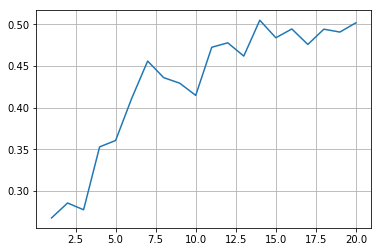

In [197]:
plt.grid(True)
plt.plot(k_values, coherences)

In [198]:
k = 14
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 30 )
    str_descriptor = ", ".join( descriptor )
    print("\nTopic %02d: %s" % ( topic_index+1, str_descriptor ) )


Topic 01: encryption, get, widget, clipper, privacy, chip, government, dog, car, helmet, keys, administration, know, shift, technology, time, cars, auto, key, good, wiretap, enforcement, wheel, right, road, pens, want, phone, shell, sure

Topic 02: car, get, good, time, bike, 10, know, edu, back, price, got, soon, want, power, people, need, 000, buy, think, 20, gordon, surrender, banks, really, drive, pitt, money, insurance, see, work

Topic 03: mouse, drive, apple, card, centris, fpu, pin, simm, thanks, slot, port, vram, get, lc, dma, nubus, mac, cable, quadra, accelerator, modem, lciii, simms, lib, board, pds, connector, old, think, problem

Topic 04: key, clipper, nsa, keys, encryption, escrow, crypto, secure, des, warrant, deleted, rsa, chip, algorithm, cellular, captain, phones, scheme, nist, security, classified, secret, proposal, stuff, phone, tap, cryptography, decrypt, trust, cipher

Topic 05: sale, shipping, offer, drive, 00, condition, asking, controller, price, brand, sell

# Latent Sematic Analysis

In [162]:
from sklearn.decomposition import TruncatedSVD

In [163]:
k = 10
model = TruncatedSVD(n_components=k) 

W = model.fit_transform(A)
H = model.components_

In [164]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor(terms, H, topic_index, 10))
    str_descriptor = ", ".join(descriptors[topic_index])
    print("Topic %02d: %s" % (topic_index+1, str_descriptor))

Topic 01: know, people, get, think, good, time, thanks, god, please, see
Topic 02: god, people, jesus, think, believe, bible, christian, christians, life, government
Topic 03: geb, cadre, pitt, dsl, chastity, n3jxp, shameful, edu, intellect, skepticism
Topic 04: god, jesus, edu, thanks, geb, cadre, dsl, chastity, n3jxp, skepticism
Topic 05: key, chip, encryption, government, clipper, keys, file, public, program, law
Topic 06: drive, scsi, system, key, disk, card, drives, chip, ide, hard
Topic 07: windows, file, window, dos, files, program, problem, running, team, win
Topic 08: god, key, 00, game, team, edu, games, chip, jesus, 10
Topic 09: 00, edu, israel, armenian, com, sale, space, armenians, jews, people
Topic 10: drive, game, scsi, israel, team, file, disk, files, drives, jews


In [165]:
topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Accounts of Anti-Armenian Human Rights Violations in Azerbaijan #007
                 Prelude to Cur
02. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #008 Part B
                 Prelude 
03. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #012
                 Prelude to Curr
04. *******
*******  This is somewhat long, but pleas read it!!!!!!!!!!!!!!!!!
*******



Boy am i glad 
05. I am not an expert in the cryptography science, but some basic things
seem evident to me, things whi
06. Archive-name: graphics/resources-list/part3
Last-modified: 1993/04/17


Computer Graphics Resource L
07. THE WHITE HOUSE

                    Office of the Press Secretary
_________________________________
08. GREAT post Martin.  Very informative, well-balanced, and humanitarian
without neglecting the need fo
09. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #008 Part A
                 Prelude 
10. Accounts of Anti-Armenian Human Right Violations in

In [166]:
kmin, kmax = 1, 20

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = TruncatedSVD(n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


In [168]:
w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 8460 terms


In [169]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

/home/artur/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


K=01: Coherence=0.2747
K=02: Coherence=0.3913
K=03: Coherence=0.5612
K=04: Coherence=0.5196
K=05: Coherence=0.5071
K=06: Coherence=0.5122
K=07: Coherence=0.4877
K=08: Coherence=0.4643
K=09: Coherence=0.4540
K=10: Coherence=0.4321
K=11: Coherence=0.4453
K=12: Coherence=0.4350
K=13: Coherence=0.4154
K=14: Coherence=0.4086
K=15: Coherence=0.4065
K=16: Coherence=0.4088
K=17: Coherence=0.3846
K=18: Coherence=0.3840
K=19: Coherence=0.3818
K=20: Coherence=0.3906


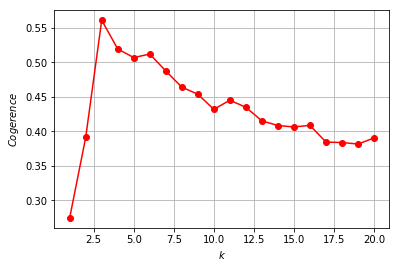

In [174]:
plt.grid(True)
plt.ylabel("${Cogerence}$")
plt.xlabel("${k}$")
plt.plot(k_values, coherences, "o-r")

In [178]:
coherences[2]

0.5612099628140523

In [176]:
k = 3
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: know, people, get, think, good, time, thanks, god, please, see
Topic 02: god, people, jesus, think, believe, bible, christian, christians, life, government
Topic 03: geb, cadre, pitt, dsl, n3jxp, chastity, shameful, intellect, skepticism, surrender


# Так как модель LSA уступает остальным двум моделям, определимся с выбором: coherence(NMF) > coherence(LDA), следовательно остановимся на данной модели

# Разработаем функционал для сопоставления документу
# ${d_0}$ - ${k}$ наиболее близких документов ${d_i , i=\{1, ..., k\}}$, обучившись на выборке ${X}$

In [49]:
class NewsRecommender():
    def __init__(self):
        self.recommended = []
        
        # Data params
        self.data              = None
        self.target_names      = None
        self.custom_stop_words = None
        self.terms             = None
        self.raw_documents     = None
        self.snippets          = None
        self.list_of_tops      = None
        
        # Model params
        self.H           = None
        self.W           = None
        self.A           = None
        self.A_shape     = None
        self.optimal_k   = None
        self.text_sample = None
        
    def recommend(self, k):
        
        # Getting vector of parameters of our text sample,
        # where (as far as i undertood) contains
        # such elements, that i-th element (i = 1:20)
        # represents relationship between i-th topic 
        # and out sample text
        self.text_sample_params = self.W[-1]
        
        tmp_W = np.delete(self.W, -1, 0)
        
        self.list_of_tops = np.argsort(sklearn.metrics.pairwise.euclidean_distances(tmp_W, [self.text_sample_params]), axis=0)
        
        for i in range(k):
            current_topic = self.data[self.list_of_tops[i][0]]
            
            print("=" * 20, "Topic %3d" % (i), "=" * 20)
            print(current_topic)
            
            self.recommended.append(current_topic)
        
        self.recommended
    
    def train(self, text_sample):
        
        self.text_sample = text_sample
        
        # Texts - array(corpus) of docs, where docs may be words or sentences
        print("Importing data...", end="")
        self.__import_data__()
        print("Done\n")
        
        print("Importing stopwords...", end="")
        self.__import_stopwords__()
        print("Done\n")
        
        self.__create_model__()
    
    def __create_model__(self):
        # Data preprocessing
        self.raw_documents = []
        self.snippets = []
        for line in self.data:
            text = line.strip()
            self.raw_documents.append(text.lower())
            self.snippets.append(text[0 : min(len(text), 300)])

        # Applying tf-idf
        vectorizer = TfidfVectorizer(stop_words=self.custom_stop_words, min_df=20)
        self.A = vectorizer.fit_transform(self.raw_documents)
        self.A_shape = self.A.shape
        self.terms = vectorizer.get_feature_names()
        
        # Applying NMF
        self.optimal_k = 20
        model = NMF(init="nndsvd", n_components=self.optimal_k) 
        self.W = model.fit_transform(self.A)
        self.H = model.components_
        
    def __get_descriptor__(self, topic_index, top):
        top_indices = np.argsort(self.H[topic_index,:])[::-1]
        top_terms = []
        for term_index in top_indices[0:top]:
            top_terms.append(self.terms[term_index])
        return top_terms
    
    def __import_stopwords__(self):
        self.custom_stop_words = []
        with open("stopwords.txt", "r") as f:
            for line in f.readlines(): self.custom_stop_words.append(line.strip().lower())
                
    def __get_descriptor__(self, terms, H, topic_index, top ):
        top_indices = np.argsort( H[topic_index,:] )[::-1]
        top_terms = []
        for term_index in top_indices[0:top]:
            top_terms.append( terms[term_index] )
        return top_terms

    def __import_data__(self):
        
        try:
            import sklearn
            from sklearn.feature_extraction.text import TfidfVectorizer
            from sklearn.datasets import fetch_20newsgroups
            self.data = fetch_20newsgroups(subset='train',
                                           remove=('headers',
                                                   'footers',
                                                   'quotes'))
            self.target_names = self.data.target_names
            self.data = self.data.data
            self.data.append(self.text_sample)
        except:
            print("I/O Error")

In [70]:
def unittest():
    
    # News and articles from BBC news 2017
    news = [None]*3
    
    news[0] = ('The Armenian Genocide also known as the Armenian Holocaust' 
            'was the Ottoman governments systematic extermination of 1.5'   
            'million Armenians, mostly citizens within the Ottoman Empire'
            'and its successor state, the Republic of Turkey.')
    
    news[1] = ("This Healey typifies the genre of affordable British post-World War II"
             "sports cars. Exported to the US in droves, these cars helped rescue the"
             "island’s motor manufacturers. (The first car sold for Mattel’s Barbie doll"
             "was, in fact, a pink Healey.) The 3000, designed by the famed racer and "
             "engineer Donald Healey and assembled by the giant British Motor Corporation,"
             "debuted to acclaim in 1959. By the time the more powerful MKIII version bowed"
             "in 1963, the roadster was fully developed and had authored a successful"
             "history in motorsport, and even a few production-car speed records. (Martyn Goddard)")
    
    news[2] = ("He was speaking after Turkey's military incursion into northern Syria to fight"
             "the Kurdish YPG militia at the weekend. Turkey sees the group as terrorists,"
             "but they have been crucial in a US-led coalition against the Islamic State (IS) group."
             "Ankara said the US had to stop backing the YPG if they wanted cooperation."
             "Thousands of civilians in the northern Syrian region of Afrin are reportedly"
             "trying to flee as Turkey continues its ground offensive. The UN Security"
             "Council has been meeting to discuss the operation, as well as the wider"
             "humanitarian situation in Syria. Turkey says its troops have seized territory"
             "from the Kurdish militia. It believes the fighters are an extension of the"
             "Kurdistan Workers Party (PKK), which has fought for Kurdish autonomy in Turkey"
             "for three decades. The YPG denies any direct links to the group.")
    
    model = NewsRecommender()
    
    for article in news:
        model.train(article)
        model.recommend(2)
    
    return 0

In [71]:
# Run tests
unittest()

Importing data...Done

Importing stopwords...Done

==================== Topic   0 ====================
04/16/93 1045  ARMENIA SAYS IT COULD SHOOT DOWN TURKISH PLANES

By David Ljunggren

MOSCOW, April 16, Reuter - Armenia accused Turkey on Friday of flying weapons
x and troops across Armenian airspace to Azerbaijan and strongly hinted it
might try to shoot the planes down, local journalists in Yerevan said.

Separately, Itar-Tass news agency said Armenian forces had halted their latest
offensive which has swallowed up one-tenth of Azerbaijan and sent tensions in
the Transcaucasian region soaring.

The journalists in the Armenian capital quoted Armen Duliyan, head of the
Armenian defence ministry press centre, as saying Ankara had been sending 
planes up to 15 times a day to Azerbaijan with arms and troops.

It looks as though the Armenian leadership will have to warn Turkey about
the impermissibility of such actions," the journalists quoted Duliyan as 
saying.

"If such steps are pursu

0